In [21]:
# ! pip install --upgrade pip
# ! pip install numba ipympl

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import os
from metavision_core.event_io import RawReader, EventsIterator
from metavision_ml.preprocessing import histo
import ipywidgets as widgets

In [23]:
# notebook | inline | widget
%matplotlib widget

Constants

In [24]:
MAX_EVENTS = 1_000_000_000

In [25]:
paths = {e.lower().replace('.raw', '') : f'../data/raw/{e}' for e in os.listdir('../data/raw') if '.raw' in e}
FILENAMES = sorted(list(paths.keys()))
print(*sorted(paths.keys()))

a1 a2 a3 a4 b1 b2 b3 b4


Data loading functions

In [26]:
def _get_n_events(rawreader):
    rawreader.reset()
    while not rawreader.done:
        rawreader.seek_event(MAX_EVENTS // 100)
    n_events = rawreader.current_event_index()
    rawreader.reset()
    return n_events

def read_file_raw(fpath):
    rawreader = RawReader(fpath, max_events=MAX_EVENTS)
    n_events = _get_n_events(rawreader)
    events = rawreader.load_n_events(n_events)
    assert events.shape[0] < MAX_EVENTS, 'too many events in file'
    return events

def read_file_chunk(fpath, delta_t, t_start):
    rawreader = RawReader(fpath)
    rawreader.seek_time(t_start)
    events = rawreader.load_delta_t(delta_t)
    return events

def read_file_chunk_idx(fpath, delta_t, idx):
    rawreader = RawReader(fpath)
    rawreader.seek_time(delta_t * idx)
    events = rawreader.load_delta_t(delta_t)
    return events

Plotting functions

In [27]:
def plot_event_count(file, delta_t, t_start, n_bins, up_down=True):
    x_1s = read_file_chunk(fpath=file, delta_t=delta_t, t_start=t_start)
    print(f'{x_1s.shape[0]:,} events')
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,4))#, dpi=200)
    fig.suptitle(f'event count over time ($t_{{total}}=${delta_t:,.0f}µs, ' + \
                 f'$t_{{bin}}=${delta_t/n_bins:,.0f}µs, $t_{{start}}$={t_start/1e6:,.0f}s)')
    if up_down:
        up_data = np.histogram(x_1s[x_1s['p'] == 1]['t'], bins=n_bins)
        down_data = np.histogram(x_1s[x_1s['p'] == 0]['t'], bins=n_bins)
        ax.bar(up_data[1][:-1], up_data[0], width=up_data[1][1]-up_data[1][0])
        ax.bar(down_data[1][:-1], -1*down_data[0], width=down_data[1][1]-down_data[1][0])
    else:
        ax.hist(x_1s['t'], bins=n_bins, rwidth=0.9);
    plt.tight_layout()

In [28]:
def histogram_for_file(fpath):
    xypt = read_file_raw(fpath)
    hist = np.zeros((1, 2, 480, 640))
    histo(xypt, hist, total_tbins_delta_t=xypt['t'].max())
    return hist

def plot_histogram_for_file(fpath, pol=0, ax=None):
    hist = histogram_for_file(fpath)
    if ax is None:
        _, ax = plt.subplots()
    ax.imshow(hist[0,pol,:,:])
    return hist

def plot_histogram(hist, pol=0, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.set_title(f'pol={pol}')
    ax.imshow(hist[0,pol,:,:])

Testing the data loading

In [29]:
# read_file_raw('../data/raw/A1.raw').shape
# # (220 781 207,)

In [30]:
# (lambda x: (x.shape, x[0].shape))(np.load('data/compressed/A1.npy', allow_pickle=True))
# # ((6112,), (15206,))

### plot event count per frame

In [31]:
arr = read_file_raw('../data/raw/A1.raw')

In [32]:
arr.shape, arr['t'].max(), arr['t'].min(), arr['t'].max() / 1e3

((220781207,), 61115652, 32, 61115.652)

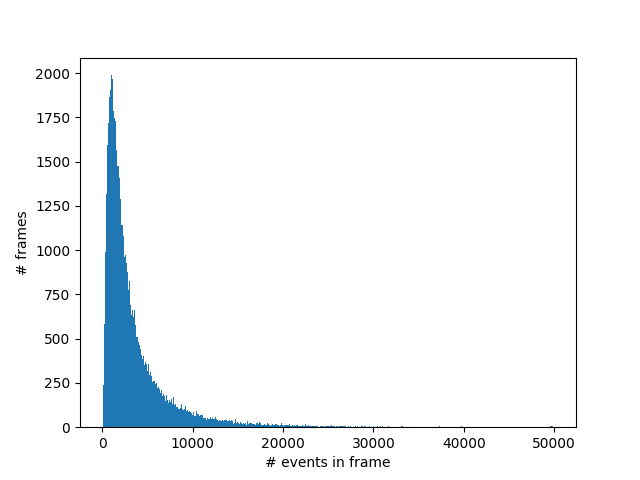

In [33]:
plt.close()
x = arr['t'].copy() // 1e3
h = np.histogram(x, bins=int(x.max()-x.min()+1))
plt.hist(h[0], bins=500)
plt.xlabel('# events in frame')
plt.ylabel('# frames')
plt.show()

## Visualize polarity symmetry?

In [34]:
@widgets.interact(filename=FILENAMES, t_start=widgets.BoundedFloatText(value=1., min=0., max=60., step=0.1),
                  duration=[0.1, 0.01, 0.001, 1.0], n_bins=[1_000, 3_000])
def f(filename, t_start, duration, n_bins):
    plot_event_count(paths[filename], t_start=t_start*1e6, delta_t=duration*1e6, n_bins=n_bins)
    plt.show()

interactive(children=(Dropdown(description='filename', options=('a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4'…

## Histograms

Of the whole trial

In [35]:
a1_hist = histogram_for_file(paths['a1'])
b1_hist = histogram_for_file(paths['b1'])

In [36]:
a = a1_hist[0,0,:,:]
print(f'A1, pol 0: µ={a.mean():.2f}')
a = b1_hist[0,0,:,:]
print(f'B1, pol 0: µ={a.mean():.2f}')

a = a1_hist[0,1,:,:]
print(f'A1, pol 1: µ={a.mean():.2f}')
a = b1_hist[0,1,:,:]
print(f'B1, pol 1: µ={a.mean():.2f}')

A1, pol 0: µ=0.89
B1, pol 0: µ=0.68
A1, pol 1: µ=0.62
B1, pol 1: µ=0.73


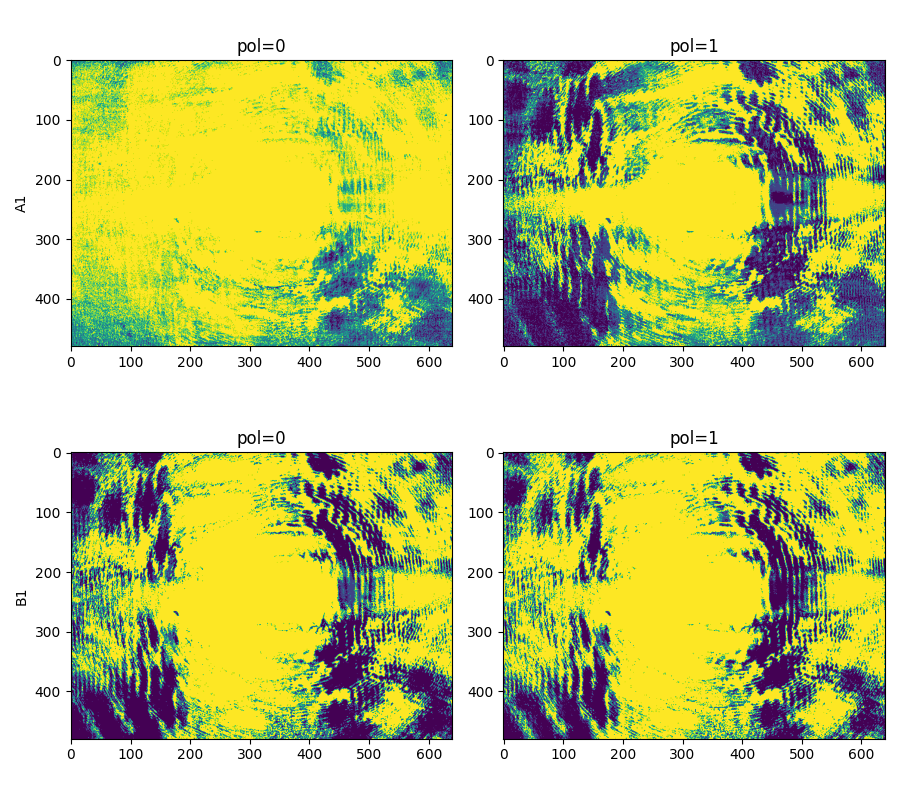

In [37]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(9, 8))
axs[0][0].set_ylabel('A1')
axs[1][0].set_ylabel('B1')
plot_histogram(a1_hist, pol=0, ax=axs[0][0])
plot_histogram(a1_hist, pol=1, ax=axs[0][1])
plot_histogram(b1_hist, pol=0, ax=axs[1][0])
plot_histogram(b1_hist, pol=1, ax=axs[1][1])
plt.tight_layout();

## Visualizing frames

In [38]:
def plot_hists_helper(fileidx, delta_t_ms, fig_name):
    chunks = [read_file_chunk(paths['a' + str(fileidx)], delta_t=delta_t_ms*1e3, t_start=10_000_000 + i*1_000) for i in range(10)]
    hists = [np.zeros((1, 2, 480, 640)) for _ in chunks]
    for i in range(len(hists)):
        histo(chunks[i], hists[i], chunks[i]['t'].max() - chunks[i]['t'].min())
    chunks2 = [read_file_chunk(paths['b' + str(fileidx)], delta_t=delta_t_ms*1e3, t_start=10_000_000 + i*1_000) for i in range(10)]
    hists2 = [np.zeros((1, 2, 480, 640)) for _ in chunks2]
    for i in range(len(hists2)):
        histo(chunks2[i], hists2[i], chunks2[i]['t'].max() - chunks2[i]['t'].min())
    plot_hists([hists[:4], hists2[:4]], fileidx, fig_name=fig_name)

In [39]:
def plot_hists(hists, title=None, fig_name=None):
    """Plots the histograms in `hists` along the x-axis, with polarity on the y-axis."""
    NCOLS = len(hists[0])
    fig, axs = plt.subplots(ncols=NCOLS, nrows=4, sharex=True, sharey=True, figsize=(9,8), num=fig_name)#, dpi=200)
    for idx in range(NCOLS):
        for file_ab_idx in [0,2]:
            for pol in range(2):
#                 if pol == 0:
#                     axs[pol+file_ab_idx][idx].set_title(f'{idx}')
#                 if idx == 0:
#                     axs[pol+file_ab_idx][idx].set_ylabel(f'pol={pol}')
                axs[pol+file_ab_idx][idx].imshow(hists[file_ab_idx//2][idx][0,pol,:,:])
                axs[pol+file_ab_idx][idx].set_yticks([])
                axs[pol+file_ab_idx][idx].set_xticks([])
    if title:
        fig.suptitle(title)
    plt.tight_layout()

interactive(children=(Dropdown(description='fileidx', options=(1, 2, 3, 4), value=1), Dropdown(description='de…

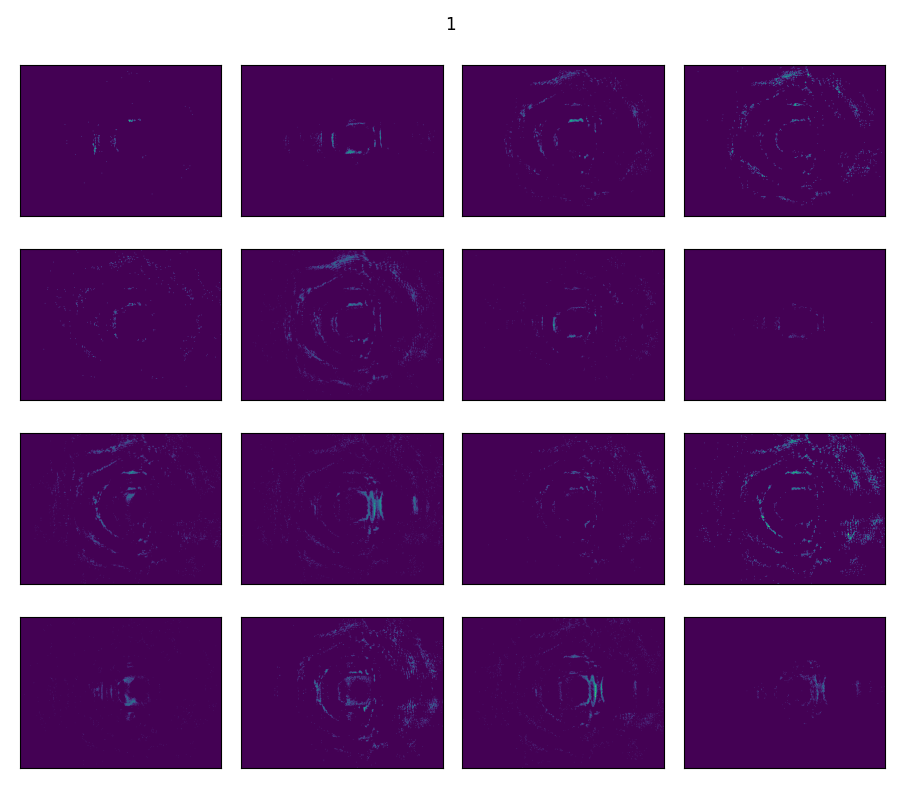

In [40]:
@widgets.interact(fileidx=range(1,5), delta_t_ms=[1, 5, 10, 0.1, 0.01])
def vis_frame(fileidx, delta_t_ms):
    plt.close('frame viz')
    plot_hists_helper(fileidx, delta_t_ms, fig_name='frame viz')